# Notebook Objective and Setup

BGG09 contains a single-user start-to-finish recommendation flow, EXCEPT for the cold-start protocol which is not yet implemented.

The system will:
- Take a BGG user id
- Obtain user's rated items from BGG via API call
- (Not yet implemented) check for sufficient ratings and engage cold-start protocol if needed
- Synthesize ratings if under the limit
- Evaluate user neighborhood and get recommendations
- Serve recommendations in descending order

In [1]:
import pandas as pd
import numpy as np
import requests
import regex as re
import time
import os
import gc
import copy
import json
from statistics import mean

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 

from scipy import spatial

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Notebook Functions

### Get User from BGG

In [2]:
def get_user_ratings(username):
    '''
    Get detailed information on the user
    
    Inputs: username, must be a valid BGG username
    
    Outputs:
    user: user as dataframe row
    user_ratings_dates: user rate date in dataframe row
    '''
    
    # set the API call path
    user_path = re.sub("\s+", "+", username)
    path = "https://www.boardgamegeek.com/xmlapi2/collection?username="+user_path+"&rated=1&stats=1"
    
    # start logging time
    start = time.time()# log the start time for this entry
    
    # print the path to confirm
    print(path)
    
    # set initial flag to False
    flag = False
    
    # run while flag is false:
    while flag == False:
        
        print("Retrieving page")
        
        # get the page
        page = requests.get(path) # get the page
        game_page = BeautifulSoup(page.content, "xml") # parse the page with beautifulsoup        
        
        # if the page returns errors,
        if game_page.find('errors') != None:
            
            # the username is invalid. Break out of the function.
            print("Invalid username")
            break
        
        # if the page returned no errors,
        else: 
            # Try to print the total number of user items
            try:
                print(int(game_page.find('items')['totalitems']))
                # if the print was successful, set the flag to True and return to the flag check
                flag = True
                continue
            # if the print failed, pause the timer 1 second and return to the flag check
            except:
                print("failed, pausing")
                time.sleep(1)
                continue
    
    # This section will begin once the flag == True
    
    # find all rated items on page
    rated_items = game_page.find_all("item")
    
    # make lists for game_id, game_ratings, modified_record date, and a dictionary to hold all
    game_ids = []
    game_ratings = []
    all_ratings = {}

    # for each item in the rated items:
    for game in rated_items:
        # get game name
        name = game.find("name").text
        # get BGG Id
        game_id = game["objectid"] 
        # Get user's rating for game
        rating = float(game.find("rating")["value"])
        # Get date of rating
        date_rated = game.find("status")["lastmodified"]
        # append game id to correct
        game_ids.append(game_id)
        # append game rating to correct list
        game_ratings.append(rating)
        # set in dictionary rating for game_id
        all_ratings[game_id]=rating
    
    # make dictionary of raw ratings for user
    raw_ratings_dict = {}
    # set in dictionary all ratings for user
    raw_ratings_dict[username] = all_ratings
       
    # Wait .5 seconds
    time.sleep(.5)        
    
    return raw_ratings_dict


### Make User Dictionary

In [3]:
def make_user_dictionary(user_items, user, game_ids):
    '''
    Takes in user's rated items, a specific user to retrieve, and a list of game_ids
    Get the mean for the user
    Builds a list of user's rated items and subtracts user mean from all ratings
    Builds a corresponding list of game ids for the rated games
    Gets intersection of user's rated ids with the overall game_ids
    Stores user game_id:rating in user ratings dictionary 
    Returns the user dictionary
    
    Inputs: 
    user_items: dataframe column of user's rated items
    user: user to retrieve
    game_ids: the game_ids we are using in our recommender
    
    Outputs:
    overall_user: user dictionary with user's ratings
    '''
    
    user_ratings = np.array(list(user_items.values()))
    
    # get the mean rating for that user
    user_mean = np.mean(user_ratings)
    
    # normalize the ratings for that user by subtracting their mean from all ratings, store in list
    game_ratings_normed =  list(user_ratings - user_mean)
    
    # Get a list of all of the game IDs that the user rated
    users_game_ids = list(user_items.keys())
    
    # get the set of usable game ids
    game_ids_set = set(game_ids).intersection(set(users_game_ids))
    
    # make user storage dictionary
    user_ratings = {}
    
    # for the key/value pairs of game_ids and normalized ratings
    for key, value in zip(users_game_ids, game_ratings_normed):
        user_ratings[key] = value
    
    # make a dictionary to store the intersected ratings
    set_dictionary = {}
    
    # for each matching key, value in game_ids and game_ratings for the user
    for item in game_ids_set:
        set_dictionary[item] = user_ratings[item]

    # store the user's ratings
    overall_user = set_dictionary
    
    return overall_user

### Produce Synthetic Ratings

In [4]:
def produce_synthetic_ratings(user, temp_users_dictionary, num_ratings_create):
    '''
    Takes in a dictionary of user's ratings and the number of ratings to synthesize
    Synthesizes ratings and creates a dictionary of all synthesized ratings for the user
    Returns synthesized ratings
    
    Inputs:
    user: the user id to create ratings for
    temp_users_dictionary: dictionary of specific user's real ratings
    num_ratings_create : simple number. # Ratings to make in the run.
    
    Outputs:
    user_comps_dict : dictionary of synthesized ratings specifically for user
    '''
    # start at iteration 0
    iteration = 0
    
    # set up dict to store all specific comps for this user
    users_comp_dict = {}

    # populate the comps with the user's baseline items
    for item in temp_users_dictionary:  
        users_comp_dict[item] = [1, 1, item, 0, temp_users_dictionary[item]]
       
    # while the list of items that the user rated is < the number of ratings needed:
    while len(users_comp_dict.keys()) < num_ratings_create:
        
        users_rated_items = list(temp_users_dictionary.keys())
        
        iteration += 1 # advance the iteration
        
        new_items = [] # make a list to hold the items for this iteration        
        
        # for each rated item:
        for rated in users_rated_items:

            # get rating for current item
            rated_rating = temp_users_dictionary[rated]
        
            # get current best comp:
            current_position = 0
            current_comp = game_comps_byid_lookup[rated][0][current_position]
            
            while current_comp in new_items:
                
                # increment position
                current_position+=1 
                
                # reset current comp to new position
                current_comp = game_comps_byid_lookup[rated][0][current_position]

                # continue back to check
                continue
            
            # any time the current comp is in users_rated_items already:
            while current_comp in users_comp_dict.keys():
                
                # increment position
                current_position+=1 
                
                # reset current comp to new position
                current_comp = game_comps_byid_lookup[rated][0][current_position]

                # continue back to check
                continue
            
            # The next section activates once the current comp is not already in the user's rated items
            
            # getting similarity of the current comp
            comp_similarity = game_comps_byid_lookup[rated][1][current_position]
              
            # get the synthetic rating for the item by taking the rating of the base item * similarity
            synthetic_rating = rated_rating * comp_similarity
        
            # get the overall confidence of this rating 
            # confidence = confidence of prior item * similarity of current item
            confidence = users_comp_dict[rated][0] * comp_similarity

            # add this item to the list of new items we are adding to the ratings this round
            new_items.append(current_comp)
            
            # make the user's comp dict
            users_comp_dict[current_comp] = [confidence, comp_similarity, rated, iteration, synthetic_rating]
            
            # update the temporary dictionary with the synthetic rating for the item
            temp_users_dictionary[current_comp] = synthetic_rating
        
        continue

    print("End length of rated items is "+str(len(users_comp_dict))+'\n')

    return users_comp_dict

In [5]:
def sort_synthetic_ratings(user, synthetic_users_dictionary, user_comps_dict, original_num_ratings, desired_ratings):
    '''
    Takes the user's synthesized comps dict, the original number of ratings the user made, 
    and the desired number of ratings the user needs.
    Creates a df sorting the synthesized ratings by confidence level, 
    keeping the highest confidence if an item was recommended more than once.
    Evaluates number of ratings needed to reach 500 and keeps only that many ratings with the highest confidence.
    For each item kept, logs the synthetic rating to the user;s dictionary
    
    Inputs:
    user: specific user to sort
    synthetic_users_dictionary: reference to the dictionary of synthesized items
    user_comps_dict: dictionary of synthesized ratings specifically for user
    original_num_ratings: The number of ratings the user actually rated
    desired_ratings: the number of ratings needed by the user
    
    '''
    
    # showing synthetic ratings only
    user_comps_df = pd.DataFrame(user_comps_dict.values(), index=user_comps_dict.keys(), columns=['OverallConfidence', 'SimtoLast', 'RecFrom', 'DegreesAway', 'SyntheticRating']).sort_values('OverallConfidence', ascending=False).drop_duplicates(keep='first')
    
    # get a list of the ratings to keep (past the real ratings)
    keep_items = list(user_comps_df[original_num_ratings:desired_ratings].index)

    # for each item that we keep,
    for item in keep_items:
    
        # add the rating to the real storage dictionary
        synthetic_users_dictionary[user][item] = user_comps_df.loc[item]['SyntheticRating']
    

## Collaborative Filtering

In [6]:
def get_user_similarity(this_dictionary, user_a, all_users_ratings, user_items, v):
    '''
    Takes in a user and dictionary of other users and their game ratings. 
    Finds users_b who have an intersection of at least v rated items (both have rated the same v items). 
    Calculates the cosine distance between user_a and each qualifying user_b.
    Stores similarity to users_b in similarity_dictionary and returns similarity_dictionary.
    
    Inputs:
    this_dictionary: existing similarities dictionary in case a similarity already exists between users
    user_a: The user that we are finding neighbors for
    all_users_ratings: all users in the system
    user_items: the items that user_a has rated
    v: number of items the users must have in common to have their distance scored and recorded
    
    Outputs:
    similarity_dictionary: dictionary with similarity between user_a and each other users with a set match
    
    '''
    
    # start a list for the user distances
    similarity_dictionary = {}
    
    # for each user b in the dictionary:
    for user_b in all_users_ratings:
        
        if user_b == user_a:
            continue
               
        else:
            
            # get a list of the user b reviewed items
            other_user_items = list(all_users_ratings[user_b].keys())
        
            # determine the intersection of the items for user a and user b
            intersection_set = set.intersection(set(user_items), set(other_user_items))
            
            if len(intersection_set) > v:
                
                if user_b in this_dictionary[user_a]:
                    # append the distance to the 
                    similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
                    pass
                
                else:
                
                    # make list to store each user a and user b ratings
                    user_a_ratings = []
                    user_b_ratings = []
        
                    # for each item in the intersection set of mutually reviewed items
                    for item in intersection_set:
            
                        # append user a ratings for the items
                        user_a_ratings.append(synthetic_users_dictionary[user_a][item])
                        # append user b ratings for the items
                        user_b_ratings.append(all_users_ratings[user_b][item])
            
                    # calculate spatial distance between the two users    
                    users_similarity = 1 - (spatial.distance.cosine(user_a_ratings,user_b_ratings))
                
                    # append the distance to the   
                    this_dictionary[user_a][user_b] =  users_similarity
                    this_dictionary[user_b][user_a] =  users_similarity
                
                    # append the distance to the 
                    similarity_dictionary[user_b] = users_similarity
        
            else: continue
    
    return similarity_dictionary

In [7]:
def get_estimated_ratings(all_users_ratings, similarity_dictionary, user_mean, k, n, synth=False):
    '''
    Takes in a distance dictionary and the user_a mean.
    Finds the k closest users
    
    Inputs: 
    all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
    similarity_dictionary: dictionary of distances between user_a and each qualifying user_b
    user_mean: the rating mean of user_a
    k: number of neighbors to consider for making ratings predictions
    n: number of minimum neighbors that rated a potential item for it to be recommended
    synth=True: if using synthetic ratings or actual values
    
    Outputs:
    user_predicted_ratings: Estimated item ratings for user_a
    '''
    
    # if we are using synthetic values,
    if synth==True:
        # sort the similarity dictionary and take those above .8 similarity
        sorted_similarities = dict(sorted(similarity_dictionary.items(), key=lambda x: x[1], reverse=True))
        temp = pd.DataFrame(sorted_similarities.values(), index=sorted_similarities.keys())
        temp = temp.loc[temp[0]>=.8]
        neighbors_lookup = temp.to_dict(orient='dict')[0]
        my_neighbors = list(temp.index)
    
    # if we are using real data, take top k neighbors
    else:
        neighbors_lookup = dict(sorted(similarity_dictionary.items(), key=lambda x: x[1], reverse=True)[:k])
        my_neighbors = list(neighbors_lookup.keys())

    # make a dictionary to store the predicted ratings for the user
    user_predicted_ratings = {}
    
    start = time.time()
    
    weighted_ratings = {}
        
    # for each user in my neighbors:
    for user in my_neighbors:
        # deep copy their ratings to the weighted ratings dictionary
        weighted_ratings[user] = copy.deepcopy(all_users_ratings[user])
        # for each item they rated:
        for item in weighted_ratings[user]:
            # weight their rating by similarity
            weighted_ratings[user][item] = weighted_ratings[user][item] * neighbors_lookup[user]
    
    # for each item in the game_ids,
    for item in game_id_lookup.keys():
        
        # change the item to a string, because the user dictionaries have string keys
        item = str(item)
        
        # set the number of ratings and base rating to 0 for this item
        num_ratings = 0
        base_rating = 0
        
        # for each neighbor in the user_a neighbor list,
        for neighbor in my_neighbors:
            
            # if the item we are working on is in the neighbor's actual ratings, 
            if item in weighted_ratings[neighbor].keys():
                
                # get the user's pre-weighted rating
                my_rating = weighted_ratings[neighbor][item]
                
                # add the rating to the base_ratings score for this item
                base_rating+= my_rating
                
                # add 1 to the number of ratings for this item
                num_ratings += 1
        
        # check that this item had at least n ratings added;
        if num_ratings>=n:
            # if so, the rating to add is the base_rating/num_ratings
            total_rating = (base_rating/num_ratings) + user_mean
            
        # if the item had <= n ratings added, go to the next item
        else: continue
        
        # if the total rating ends up over 10, set it to 10 (the max)
        if total_rating > 10:
            total_rating=10
        
        # put the predicted rating in the user predictions dictionary
        user_predicted_ratings[item] = total_rating
    
    # print a report about the user
    total_ratings_created = len(user_predicted_ratings)
    print("Predicted "+str(total_ratings_created)+' ratings')
        
    return user_predicted_ratings

In [8]:
def score_ratings(user_real_dict, user_predicted_ratings, user_mean):
    '''
    Takes in actual ratings and predictions
    Gets the intersection of items that user actually rated, and prediction for that item
    Gets MAE and RMSE of actuals vs predictions
    Get recall (% of user's relevant items predicted as recommended)
    
    Inputs: 
    user_real_dict: single user's actual ratings, use REAL ratings dictionary only
    predicted_dictionary: dictionary of single user's predicted ratings
    user_mean: user's mean rating
    
    Outputs:
    user_mae, user_rmse: user's MAE and RMSE
    recall: % of user's actual relevant items that were predicted and correctly recommended
    
    '''
    # Make a list of all predicted item ids for user
    predicted_items = list(user_predicted_ratings.keys())
    #print(predicted_items)
    
    # make a list of all actual rated item ids for user
    actual_rated_items = list(user_real_dict.keys())

    # the intersection of items both rated and predicted
    real_rated_and_predicted = list(set.intersection(set(actual_rated_items), set(predicted_items)))


    # make a dictionary for new recommendations
    all_recommendations = {}
      
    # make list for recommended items
    recommended_items = []
    
    # for each item in the recommentation list,
    for item in predicted_items:
               
        # if the item is rated higher than the user_mean (user mean)
        if user_predicted_ratings[item] > user_mean:
    
            # append to the recommendations dictionary
            all_recommendations[item] = user_predicted_ratings[item]
            
            # append to the recommendations list
            recommended_items.append(item)
    
    # recommended = # of recommended items 
    recommended = len(recommended_items)    
    
    # relevant items are user rated items that have a true value over the user's mean
    # start at 0 and will add
    relevant = 0
    
    # recommended items that are relevant are items where the recommendation and the real value are over the user's mean
    # start at 0 and will add
    rec_and_rel = 0    

    # for each item that was both actually rated and predicted:
    for item in real_rated_and_predicted:
        # get the real item rating
        item_rating = user_real_dict[item]+user_mean
        # if the item was rated over the user's mean:
        if item_rating > user_mean:
            # add 1 to relevant items
            relevant +=1     
        # if the item is in the recommended list:
        if item in recommended_items:
            # if the prediction is over the user mean:
            if user_predicted_ratings[item] > user_mean:
                # add one to rec and rel items
                rec_and_rel +=1
    
    # if there were no recommendations or relevant items, recall is 0
    if len(all_recommendations)==0:
        recall = 0
    elif relevant==0:
        recall = 0
    # otherwise, calculate recall
    else:
        recall = round((rec_and_rel/relevant)*100, 2)
            
            
    # MAE and RMSE:
    
    # make lists for actuals and predictions
    y_actual = []
    y_preds = []
    
    # for items in the real and predicted intersection,
    for item in real_rated_and_predicted:
        # append the scores to real and predicted lists
        y_actual.append(user_real_dict[item])
        y_preds.append(user_predicted_ratings[item])  
    
    # if there were no predictions, skip this
    if len(y_preds)==0:
        print("No ratings for actual predicted items. Cannot calculate MAE for this user.")
        user_mae, user_rmse = None, None
    
    # otherwise, calculate mae and rmse
    else: 
        user_mae = mean_absolute_error(y_preds, y_actual)
        user_rmse = np.sqrt(mean_squared_error(y_preds, y_actual))
          
    return user_mae, user_rmse, recall, actual_rated_items, recommended_items

In [9]:
def get_user_predictions(resources_pack, user_set, parameters, synth):
    '''
    Gets predictions for a set of users
    
    For each user, makes a list of the user's reviewed items
    Calls on get_user_similarity() to find other users with v items in common
    Calls on get_estimated_ratings() to get predictions based on k neighbors
    Gets MAE and RMSE on predictions for items user actually rated
    Stores all predictions to dictionary
    
    Inputs:
    resources_pack: collection of three dictionaries:
        all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
        real_user_ratings: dictionary of actual ratings, use REAL ratings dictionary only
        this_dictionary: ongoing similarities dictionary which is populated as users iterate 
    user_set: list of users to get predictions for
    parameters: collection of three parameters:
        v: number of required items in the intersection of two user rating sets to consider a neighbor
        k: number of neighbors to consider for neighborhood
        n: number of neighbors in neighborhood that must have rated an item for a rating to be produced
    
    Outputs:
    global_mae, global_rmse: MAE and RMSE for the user set
    global_recall: recall for these users
    predicted_ratings: dictionary of user predictions
    all_recommended_items: set of items that were recommended
    '''
    
    # start the timer
    global_start = time.time()
    
    # unpack the parameters dict
    v = parameters[0]
    k = parameters[1]
    n = parameters[2]
      
    # unpack the resources pack
    all_users_ratings = resources_pack[0]
    real_users_ratings = resources_pack[1]
    this_dictionary = resources_pack[2]
    
    # set up the predicted ratings for these users
    predicted_ratings = {}

    # set up the scoring lists for these users
    global_mae_list = []
    global_rmse_list = []
    global_recall_list = []
    
    # set storage for recommended items
    all_recommended_items = []
    
    # for the user we are calculating
    for user_a in user_set:
    
        # report on user
        print("Calculating "+user_a)
    
        # get the user's mean rating
        user_mean = mean(list(user_dictionary[user].values()))
    
        # make a list of the user_a reviewed items
        user_items = user_dictionary[user]
    
        # make a distance dictionary for this user
        similarity_dictionary={}
        
        # set our variable v equal to initial v
        v_var = v
        
        # while our distance dictionary is less than k neighbors,
        while len(similarity_dictionary) < k:
            # call the get_user_similarity to find the user's neighbors
            similarity_dictionary = get_user_similarity(this_dictionary, user_a, all_users_ratings, user_items, v_var)
            # reduce variable v by one and continue to check if we have enough k neighbors
            v_var -= 1
            continue
        
        # print the neighborhood results
        print("Found "+str(len(similarity_dictionary))+" potential neighbors in common at v: "+str(v_var+1)+" k: "+str(k)+" n:"+str(n))
    
        # call get_estimated_ratings to get predictions for user_a
        user_predicted_ratings = get_estimated_ratings(all_users_ratings, similarity_dictionary, user_mean, k, n, synth)
        
        # if there were no user predicted ratings:
        if len(user_predicted_ratings)==0:
            print("There were NO COMPS for this user")
            global_mae_list.append(0)
            global_rmse_list.append(0)
            global_recall_list.append(0) 
            continue
        
        else:
            # store the predicted ratings for the user_a
            predicted_ratings[user_a] = user_predicted_ratings
            
            # get user scores
            user_mae, user_rmse, user_recall, actual_rated_items, recommended_items = score_ratings(user_dictionary[user_a], user_predicted_ratings, user_mean)
            
            # check if there were valid user scores; if none, skip the scoring additojn
            if user_mae == None:
                continue
            # otherwise append the scores to the score lists
            else:
                global_mae_list.append(user_mae)
                global_rmse_list.append(user_rmse)
                global_recall_list.append(user_recall) 
        
        # add the recommended items to the all_recommended_items set
        all_recommended_items += recommended_items
        all_recommended_items = list(set(all_recommended_items))
          
    global_mae = mean(global_mae_list)
    global_rmse = mean(global_rmse_list)
    global_recall = mean(global_recall_list)    
    
    end_time = time.time() - global_start
        
    print("MAE for set of users: "+str(global_mae))
    print("RMSE for set of users: "+str(global_rmse))
    print("Recall for set of users: "+str(global_recall))
    print("Time elapsed: "+str(end_time))
        
    return global_mae, global_rmse, global_recall, predicted_ratings, all_recommended_items

# Needed Files

In [10]:
# dictionary of game IDs-Names

# Load games
games = pd.read_pickle('data_cleaned/games.pkl')

# lists of game ids and game names
game_ids = list(games['BGGId'].astype('str'))
game_names = list(games['Name'])

# make lookup dictionary
game_id_lookup = {}

# store ids and names in lookup dictionary
for key, item in zip(game_ids, game_names):
    game_id_lookup[key] = item

# Opening JSON file
with open('game_comps_byid_lookup.json') as json_file:
    game_comps_byid_lookup = json.load(json_file)

# load user means
user_means = pd.read_pickle('user_means.pkl')
user_means

# send the lookup table to dict
user_mean_lookup = user_means.to_dict(orient='index')

# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)
    
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)
    
# get list of users
users_list = list(real_user_ratings_dictionary_unscaled.keys())

In [11]:
# number of synthetic ratings to produce
num_ratings_create = 500

# number of ratings we will end up using
desired_ratings = 100

# Recommend for One User

Don's user name - Oberon1066

In [12]:
user = 'Threnody'

In [13]:
# start a timer
start = time.time()

# Get the user's ratings from BGG
print("Getting ratings from BGG")
user_dictionary = get_user_ratings(user)

user_mean = mean(list(user_dictionary[user].values()))

synthetic_users_dictionary = {}

user_items = user_dictionary[user]
print("\nMaking dictionary of user's rated items")
synthetic_users_dictionary[user] = make_user_dictionary(user_items, user, game_ids)
temp_users_dictionary = copy.deepcopy(synthetic_users_dictionary[user])

# get the original number of ratings by this user
original_num_ratings = len(temp_users_dictionary)

print("\nProducing synthetic ratings for user")
# call function to produce synthetic ratings
user_comps_dict = produce_synthetic_ratings(user, temp_users_dictionary, num_ratings_create) 

print("\nGetting best synthetic ratings")
# sort the synthetic ratings to get the top desired_ratings
sort_synthetic_ratings(user, synthetic_users_dictionary, user_comps_dict, original_num_ratings, desired_ratings)

temp_dict = {}
for person in real_user_ratings_dictionary_unscaled:
    temp_dict[person] = {}
temp_dict[user] = {}
    
resources_pack = [synth_user_ratings_dictionary_scaled100, user_dictionary, temp_dict]
v, k, n = 5, 250, 5
parameters = [v, k, n]

# make a list of the user_a reviewed items
user_items_synth = list(synthetic_users_dictionary[user].keys())
    
print("\nFinding most similar users to this user")
# get user similarities to this user
similarity_dictionary = get_user_similarity(resources_pack[2], user, resources_pack[0], user_items_synth, v)

# score user
print("\nGet user recommendations and score user")
mae, rmse, recall, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=True)

# make a list of all actual rated item ids
actual_rated_items = list(user_dictionary[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]

print("\nSort recommendations")
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[item]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

end = time.time()
elapsed = end-start
print("\nTotal time: "+str(elapsed)+" seconds")

# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

Getting ratings from BGG
https://www.boardgamegeek.com/xmlapi2/collection?username=Threnody&rated=1&stats=1
Retrieving page
185

Making dictionary of user's rated items

Producing synthetic ratings for user
End length of rated items is 684


Getting best synthetic ratings

Finding most similar users to this user

Get user recommendations and score user
Calculating Threnody
Found 87695 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7088 ratings
MAE for set of users: 0.4902085519916054
RMSE for set of users: 0.7145146325822205
Recall for set of users: 62.8
Time elapsed: 7.688979625701904

Sort recommendations

Total time: 14.64229679107666 seconds


,Estimated Rating
Decision at Elst: An Advanced Squad Leader Starter Kit Historical Module,8.772604
Advanced Squad Leader: Starter Kit #1,8.743208
Advanced Squad Leader: Starter Kit #2,8.700459
Star Fleet Battles: Captain's Edition Basic Set,8.631639
Advanced Squad Leader: Starter Kit #3,8.629025
Advanced Squad Leader,8.617909
Enemy Action: Ardennes,8.594610
Clinic: Deluxe Edition,8.593562
Napoleon's Triumph,8.528649
Unconditional Surrender! World War 2 in Europe,8.494808


## User visualizations

In [14]:
temp = pd.DataFrame(user_dictionary[user].values(), index=user_dictionary[user].keys())
temp['Game'] = temp.index.map(game_id_lookup)
temp['Rating'] = temp[0]
temp.reset_index(inplace=True)
temp.drop(['index', 0], axis=1, inplace=True)
temp.sort_values('Rating', ascending=False).head(100)

,Game,Rating
17,Between Two Cities,10.0
84,NaN,10.0
111,One Night Ultimate Werewolf,10.0
99,Magic: The Gathering,10.0
112,One Night Ultimate Werewolf: Daybreak,10.0
...,...,...
124,Puzzle Strike (Third Edition),7.0
169,Vegas Showdown,7.0
156,Temporum,7.0
138,Sentinels of the Multiverse,7.0


In [15]:
temp2 = pd.DataFrame(synthetic_users_dictionary[user].values(), index=synthetic_users_dictionary[user].keys())
temp2['Game'] = temp2.index.map(game_id_lookup)
temp2['Rating'] = temp2[0]+user_mean
temp2.reset_index(inplace=True)
temp2.drop(['index', 0], axis=1, inplace=True)
temp2.sort_values('Rating', ascending=False).head(20)

,Game,Rating
111,Between Two Cities,10.0
161,Pandemic Legacy: Season 2,10.0
16,Magic: The Gathering,10.0
139,Gloomhaven,10.0
144,The Grizzled,10.0
35,One Night Ultimate Werewolf: Daybreak,10.0
49,Roll Player,10.0
76,Pandemic Legacy: Season 1,10.0
72,The Castles of Burgundy,10.0
46,One Night Ultimate Werewolf,10.0


In [16]:
user_comps_df = pd.DataFrame(user_comps_dict.values(), index=user_comps_dict.keys(), columns=['OverallConfidence', 'SimtoLast', 'RecFrom', 'DegreesAway', 'SyntheticRating']).sort_values('OverallConfidence', ascending=False).drop_duplicates(keep='first')
user_comps_df['SyntheticRating'] = user_comps_df['SyntheticRating']+user_mean
user_comps_df['RecommendedItem'] = user_comps_df.index.map(game_id_lookup)
user_comps_df['Seed'] = user_comps_df['RecFrom'].map(game_id_lookup)
user_comps_df.sort_values('SyntheticRating', ascending=False).head(20)

,OverallConfidence,SimtoLast,RecFrom,DegreesAway,SyntheticRating,RecommendedItem,Seed
174430,1.000000,1.000000,174430,0,10.000000,Gloomhaven,Gloomhaven
221107,1.000000,1.000000,221107,0,10.000000,Pandemic Legacy: Season 2,Pandemic Legacy: Season 2
84876,1.000000,1.000000,84876,0,10.000000,The Castles of Burgundy,The Castles of Burgundy
463,1.000000,1.000000,463,0,10.000000,Magic: The Gathering,Magic: The Gathering
161936,1.000000,1.000000,161936,0,10.000000,Pandemic Legacy: Season 1,Pandemic Legacy: Season 1
163166,1.000000,1.000000,163166,0,10.000000,One Night Ultimate Werewolf: Daybreak,One Night Ultimate Werewolf: Daybreak
171668,1.000000,1.000000,171668,0,10.000000,The Grizzled,The Grizzled
169426,1.000000,1.000000,169426,0,10.000000,Roll Player,Roll Player
147949,1.000000,1.000000,147949,0,10.000000,One Night Ultimate Werewolf,One Night Ultimate Werewolf
168435,1.000000,1.000000,168435,0,10.000000,Between Two Cities,Between Two Cities


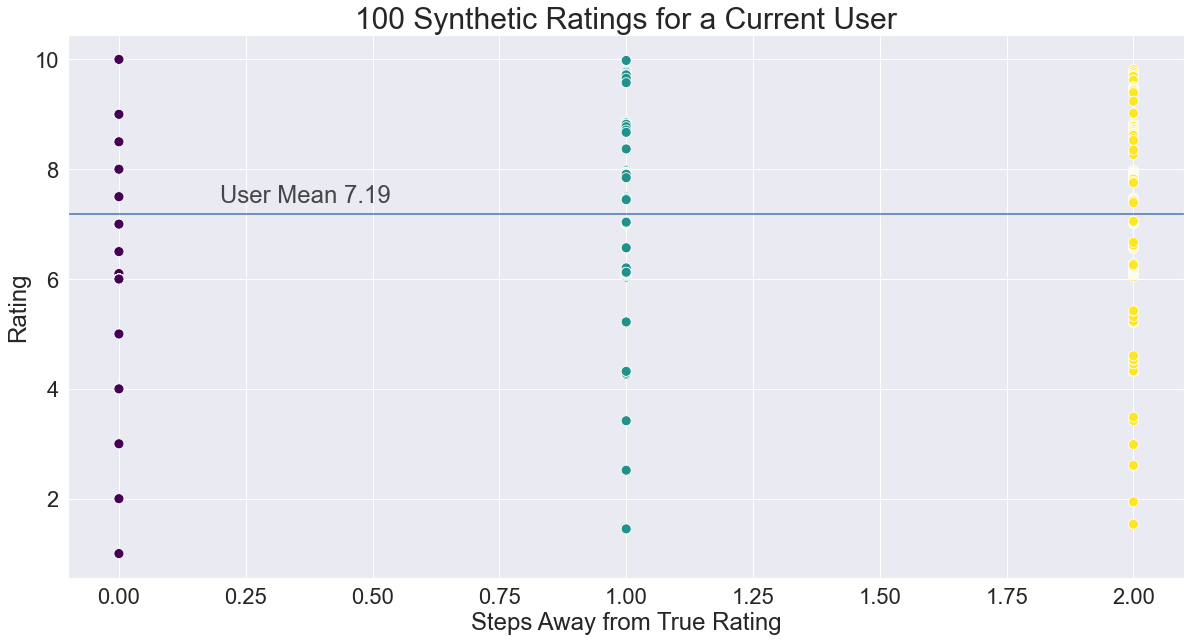

''

In [19]:
fig, ax = plt.subplots(figsize=(20,10))

sns.set(font_scale = 2) # set our font scale bigger for this vis

# scatter our data
sns.set_style('darkgrid')
scatter2 = sns.scatterplot(x="DegreesAway", y='SyntheticRating', data=user_comps_df, 
                           hue='DegreesAway', palette='viridis', s=100)
ax.axhline(user_mean)
ax.text(x=.2, y=(user_mean+.2), s='User Mean '+str(round(user_mean, 2)), alpha=0.7, color='black')

ax.get_legend().remove()

plt.title("100 Synthetic Ratings for a Current User", fontsize=30)
plt.xlabel("Steps Away from True Rating", fontsize=24)
plt.ylabel("Rating", fontsize=24)


plt.tight_layout
plt.show()
;